# XAI - Final Project
#### Moïn Danai, Bastien Potet, Maurice Lehmann 

### Global goal of the final project

In this final project, we will verify the impact of pesticides and soil care products on the health
and quality of vineyard soils in Switzerland.

To do so, we'll use a dataset composed of vineyard soil samples : 

- 104 soil samples in 2015
- 73 soil samples in 2016

For each soil sample, there exists
- 2683 features as input variables

We'll follow the proposed pipeline : 
1. Data Preparation
2. Exploratory Data Analysis (EDA)
3. Feature Selection
4. Machine Learning Models
5. Post Modelling Analysis

To fully solve this problem, we'll use : a baseline and then two different models : 
- Model A : K-Neighbours classifier
- Model B : ??? , which use grid search to tune hyper-parameters.

For each models, we'll calculate the following metrics : 
- Accuracy
- Recall
- Precision
- F1-Score
- Mean-Absolute-Error (MAE) (Bonus)

Finally, we'll try to answer the following questions : 
- What are the most relevant features (Feature Selection) in this classification problem?
- How could we predict class of 'Cu_mg_kg' in vineyard soil samples in 2016 using interpretability-oriented  machine learning (ML) models?


**In addition, we'll try to consider this problem as a regression problem,and repeat the last two
phases of the pipeline.**


### Data Preparation


In [76]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier


In [77]:

#TODO Maurice : On utilise ça ou c'est inutil ?


def cleanData(data_df):
    #Null columns
    null_columns = data_df.columns[data_df.isnull().any()]
    data_df[null_columns].isnull().sum()

    #Remove column(s) in which more than 80% of entries are null.
    for c in null_columns :
        if (data_df[c].isnull().sum() / data_df.shape[0] * 100) > 80 :
            print(c)
            data_df.pop(c)

    #If there still exists some null values inside the data set, remove the rows with a null value.
    data_df = data_df.dropna()

    #If there exists duplicate rows inside this data set, keep only one copy of each duplicate row.
    data_df.drop_duplicates(keep=False, inplace=False)
    
    return data_df

In [78]:
'''
 For each soil sample, there exists
• 2683 features as input variables
• Available in CSV files ‘ProtistAmpliconSequenceVariants_ASV_2015.csv' & ‘ProtistAmpliconSequenceVariants_ASV_2016.csv'
• ‘Cu_mg_kg' as target (output variable)
• Available as a column in CSV files 'Env_2015.csv' & 'Env_2016.csv'
'''
X_train = pd.read_csv(os.path.join('data', 'ProtistAmpliconSequenceVariants_ASV_2015.csv'), sep=';')
y_train = pd.read_csv(os.path.join('data', 'Env_2015.csv'), sep=';')
y_train = y_train['Cu_mg_kg']


X_test = pd.read_csv(os.path.join('data', 'ProtistAmpliconSequenceVariants_ASV_2016.csv'),sep=';')
y_test = pd.read_csv(os.path.join('data', 'Env_2016.csv'), sep=';')
y_test = y_test['Cu_mg_kg']

cleanData(X_train)
cleanData(X_test)

##TODO : Prendre que la colonne 'Cu_mg_kg' du y_train et y_test

print("X_train : {}".format(X_train.shape))
print("y_train : {}".format(y_train.shape))

print("X_test : {}".format(X_test.shape))
print("y_test : {}".format(y_test.shape))

X_train : (104, 2684)
y_train : (104,)
X_test : (73, 2684)
y_test : (73,)


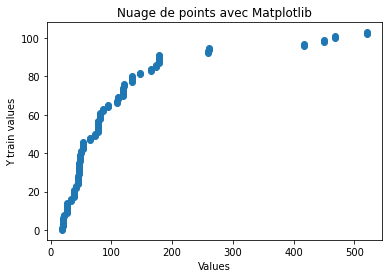

In [79]:
import matplotlib.pyplot as plt

sorted_y_train = sorted(y_train)

x = range(0, len(sorted_y_train))

plt.scatter(sorted_y_train, x)

plt.title('Nuage de points avec Matplotlib')
plt.xlabel('Values')
plt.ylabel('Y train values')

plt.show()

In [80]:
#The y_ datas (Cu_mg_kg values) are float value
#But we want to treat this problem as a classification problem,
#so we have to round the datas.
#y_train = [round(x) for x in y_train]
#y_test = [round(x) for x in y_test]

def getClass(val):
    if val < 45 : 
        return 0
    elif val < 77:
        return 1
    elif val < 134:
        return 2
    else:
        return 3
    
y_train_with_class = [getClass(x) for x in y_train]
y_test_with_class = [getClass(x) for x in y_test]

print(y_test_with_class)

[0, 0, 0, 2, 2, 1, 3, 3, 2, 3, 0, 1, 2, 1, 2, 3, 3, 1, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 3, 3, 3, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 3, 3, 3, 1, 1]


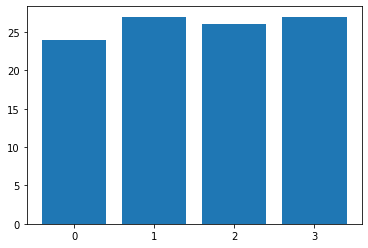

In [81]:
classes = [0,1,2,3]
y_train_sorted = sorted(y_train_with_class)
y_train_plt = []

for c in classes:
    y_train_plt.append(y_train_with_class.count(c))
plt.bar(classes, y_train_plt)
plt.xticks(classes, classes)
plt.show()

### Exploratory Data Analysis (EDA)

As we did in the previous labs, we show here the best features to use in the data set.

In [82]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import operator

def select_features(X_train, y_train, X_test, k_, score_func_):
    # configure to select a subset of features
    
    print(k_)
    
    fs = SelectKBest(score_func = score_func_ , k = k_)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def print_features(fs):
    # what are scores for the features
    scores = [[i, fs.scores_[i]] for i in range(len(fs.scores_))]
    # plot the scores
    sorted_scores = sorted(scores, key=operator.itemgetter(1))
    pyplot.figure(figsize=(10,12))
    pyplot.bar(
        [str(x[0]) for x in sorted_scores],
        [x[1] for x in sorted_scores]
    )
    pyplot.show()

    

#configure to select all features
X_train_fs, X_test_fs, fs = select_features(X_train, y_train_with_class, X_test, 20, mutual_info_classif)

print('done')

20
done


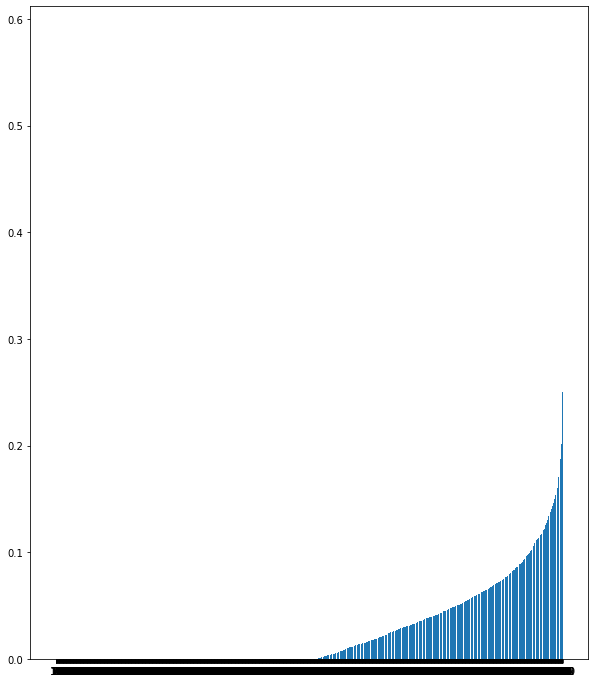

In [83]:
print_features(fs)

In [84]:
X_train.columns

Index(['Index', 'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7', 'VAR8',
       'VAR9',
       ...
       'VAR2674', 'VAR2675', 'VAR2676', 'VAR2677', 'VAR2678', 'VAR2679',
       'VAR2680', 'VAR2681', 'VAR2682', 'VAR2683'],
      dtype='object', length=2684)

In [85]:
N_features = 200

features = X_train.columns

features = features.drop('Index')

idx_features = [[i, fs.scores_[i]] for i in range(len(fs.scores_))]

sorted_features = sorted(idx_features, key=operator.itemgetter(1))
selected_sorted_features = sorted_features[-N_features:]
selected_sorted_features = [i for i, v in selected_sorted_features]

X_train_with_selected_features = X_train[features[selected_sorted_features]]
X_test_with_selected_features = X_test[features[selected_sorted_features]]

In [86]:
X_train_with_selected_features.describe()

,VAR2519,VAR1536,VAR1443,VAR215,VAR2676,VAR967,VAR90,VAR1304,VAR1701,VAR2450,...,VAR198,VAR1305,VAR457,VAR2213,VAR2011,VAR2120,VAR1127,VAR247,VAR2401,VAR1
count,104.000000,104.000000,104.0,104.000000,104.0,104.000000,104.000000,104.000000,104.0,104.0,...,104.0,104.0,104.0,104.000000,104.000000,104.0,104.0,104.0,104.000000,104.000000
mean,0.048077,0.384615,0.0,0.019231,0.0,0.019231,0.221154,0.096154,0.0,0.0,...,0.0,0.0,0.0,0.048077,1.980769,0.0,0.0,0.0,0.019231,0.019231
std,0.490290,1.294557,0.0,0.196116,0.0,0.196116,1.051644,0.794633,0.0,0.0,...,0.0,0.0,0.0,0.490290,4.770420,0.0,0.0,0.0,0.196116,0.196116
min,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
max,5.000000,9.000000,0.0,2.000000,0.0,2.000000,8.000000,8.000000,0.0,0.0,...,0.0,0.0,0.0,5.000000,29.000000,0.0,0.0,0.0,2.000000,2.000000


### Machine Learning Models

#### Baseline

accuracy_train = 0.26
accuracy_test = 0.27


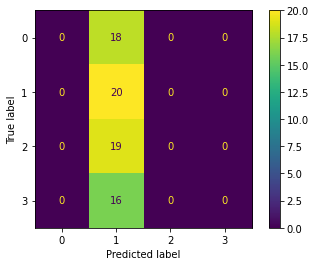

In [87]:

from sklearn.metrics import plot_confusion_matrix

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit the model
dummy.fit(X_train_with_selected_features, y_train_with_class)

# Compute test accuracy

acurracy_train = dummy.score(X_train_with_selected_features, y_train_with_class)
accuracy_test = dummy.score(X_test_with_selected_features, y_test_with_class)

print('accuracy_train = {:.2f}'.format(acurracy_train))
print('accuracy_test = {:.2f}'.format(accuracy_test))

plot_confusion_matrix(dummy, X_test_with_selected_features, y_test_with_class)

#### Model A

accuracy_train = 0.26
accuracy_test = 0.30


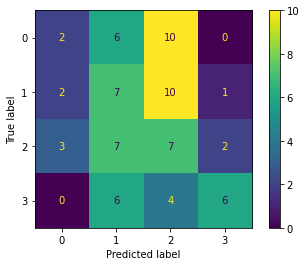

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

# Create the random forest classifier

k_class = KNeighborsClassifier(n_neighbors=5)

k_class.fit(X_train_with_selected_features, y_train_with_class)

# Accuracy on the test set
accuracy_train = k_class.score(X_train_with_selected_features, y_train_with_class)
accuracy_test = k_class.score(X_test_with_selected_features, y_test_with_class)

print('accuracy_train = {:.2f}'.format(acurracy_train))
print('accuracy_test = {:.2f}'.format(accuracy_test))

plot_confusion_matrix(k_class, X_test_with_selected_features, y_test_with_class)

#### Model B

accuracy_train = 0.26
accuracy_test = 0.30


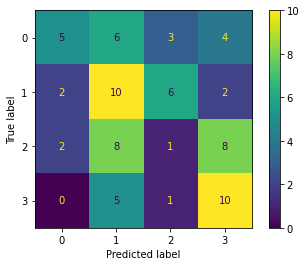

In [89]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

X_train = X_train_with_selected_features
y_train = y_train_with_class
X_test = X_test_with_selected_features
y_test = y_test_with_class

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

# Accuracy on the test set
accuracy_train = nb_classifier.score(X_train, y_train)
accuracy_test = k_class.score(X_test, y_test)

print('accuracy_train = {:.2f}'.format(acurracy_train))
print('accuracy_test = {:.2f}'.format(accuracy_test))

plot_confusion_matrix(nb_classifier, X_test, y_test)

### Post Modelling Analysis

### Optional Section

Consider this problem as a regression problem and repeat the last two
phases of the pipeline (Machine Learning Models & Post-Modelling
Analysis) to solve this regression Problem.

Mean-Absolute-Error (MAE) is a metric to evaluate the performance of
regression models. It is the mean of the absolute values of each
prediction error on all instances of the test set.

For each model, calculate MAE on test set.